<font size=6  color= 'blue' > <b>[LEPL1507] - PROJET P4</b> <br>
<br><br>
Airson Alexis<br>
Beniffou Ibrahim <br>
Henneaux Lucas <br>
Lemaire Antoine <br>
Smith Marielle <br>
Canon Théo<br>
<div style="text-align: right"> </div>

<br><br>
</font>


In [80]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.utils import to_categorical 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
from os import walk, listdir
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
import random
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [81]:
# accessing to data 

path_training = 'Retrieving_data\BelgiumTSC_Training\Training'
path_testing = 'Retrieving_data\BelgiumTSC_Testing\Testing'

nbr_class = 62 # len(next(walk(path_training))[1])  counting the number of classes 
print('number of classes : ', nbr_class)

#-----------------------------------------------------------------------------

# resol is the format for the images that we want for convenience

resol = (30,30)

#-----------------------------------------------------------------------------

# retrieving the number of images to be treated in the training folder

DIR = path_training
counter = 0
for root, dirs, files in walk(DIR) :
    for file in files:    
        if file.endswith('.ppm') or file.endswith('.jpeg'):
            counter += 1

print("number of images in the training folder : ", counter)

#-----------------------------------------------------------------------------

# Creating an image.DirectoryIterator to work over the images of the training folder 

# We rescale the images when we iterate over it and we will do a zoom and a flip  

train_datagen = ImageDataGenerator( rescale =1./255, zoom_range = 0.2, horizontal_flip = True)
training_set = train_datagen.flow_from_directory(path_training,target_size = resol,
batch_size = counter,class_mode = 'binary', color_mode='rgb')

#-----------------------------------------------------------------------------

# retrieving the number of images to be treated in the testing folder

DIR = path_testing
counter = 0
for root, dirs, files in walk(DIR) :
    for file in files:    
        if file.endswith('.ppm') or file.endswith('.jpeg'):
            counter += 1

print("number of images in the testing folder : ", counter)


#-----------------------------------------------------------------------------

# Creating an image.DirectoryIterator to work over the images of the testing folder 

# We rescale the images when we iterate over it 

test_datagen = ImageDataGenerator( rescale =1./255)
test_set = test_datagen.flow_from_directory(path_testing,target_size = resol,
batch_size = counter,class_mode = 'binary', color_mode='rgb')


number of classes :  62
number of images in the training folder :  4575
Found 4575 images belonging to 62 classes.
number of images in the testing folder :  2520
Found 2520 images belonging to 62 classes.


training_set = ensemble de 143 tuples
Chaque tuple représente 32 images (sauf le dernier, 31 images)

tuple[0] = features = tableau (32, 30, 30, 3)
tuple[1] = label = tableau (32)

plt.imshow(training_set[i][0][j]) affiche l'image n°j du paquet d'image n°i 

# talk : I don't think it's true 

In [82]:
# Storing all the information in arrays for convenience 

X_train , y_train = training_set.next()
X_test , y_test = test_set.next()

print("Shape of X_train : ", X_train.shape)
print("Shape of y_train : ", y_train.shape)
print("Shape of X_test : ", X_test.shape)
print("Shape of y_test : ", y_test.shape)

# talk : is it still necessary ?

#data augmentation
'''aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")
aug.fit(X_train)'''

Shape of X_train :  (4575, 30, 30, 3)
Shape of y_train :  (4575,)
Shape of X_test :  (2520, 30, 30, 3)
Shape of y_test :  (2520,)


'aug = ImageDataGenerator(\n\trotation_range=10,\n\tzoom_range=0.15,\n\twidth_shift_range=0.1,\n\theight_shift_range=0.1,\n\tshear_range=0.15,\n\thorizontal_flip=False,\n\tvertical_flip=False,\n\tfill_mode="nearest")\naug.fit(X_train)'

Number of each sign in the train set : 

[ 15 110  13  15  15  11  18 157  27  18  21   7  18  90  43   9   9  79
  81 231  42  43 375  15  48  42   6  18 125  33  37  63 316  12  46  60
  18  98 285 196 242 148  35  30  48  74  44 147  11  12  15  27  27 199
 118  12  95  78  15  42   9 282]

Total of signs :  4575

Number of each sign in the test set : 

[  6  27   7   6  12   3   6  90  12   0  28   0   3  39  15   0  12 183
 122 163   3  45  61  15  13   3   0   9  51  28  37  86 422   0   9 154
   0  31 213  99  48  11   9   6   3  84   6  31   0   3   0   3   0  24
  48  15  33  41   9  17  11 105]

Total of signs :  2520


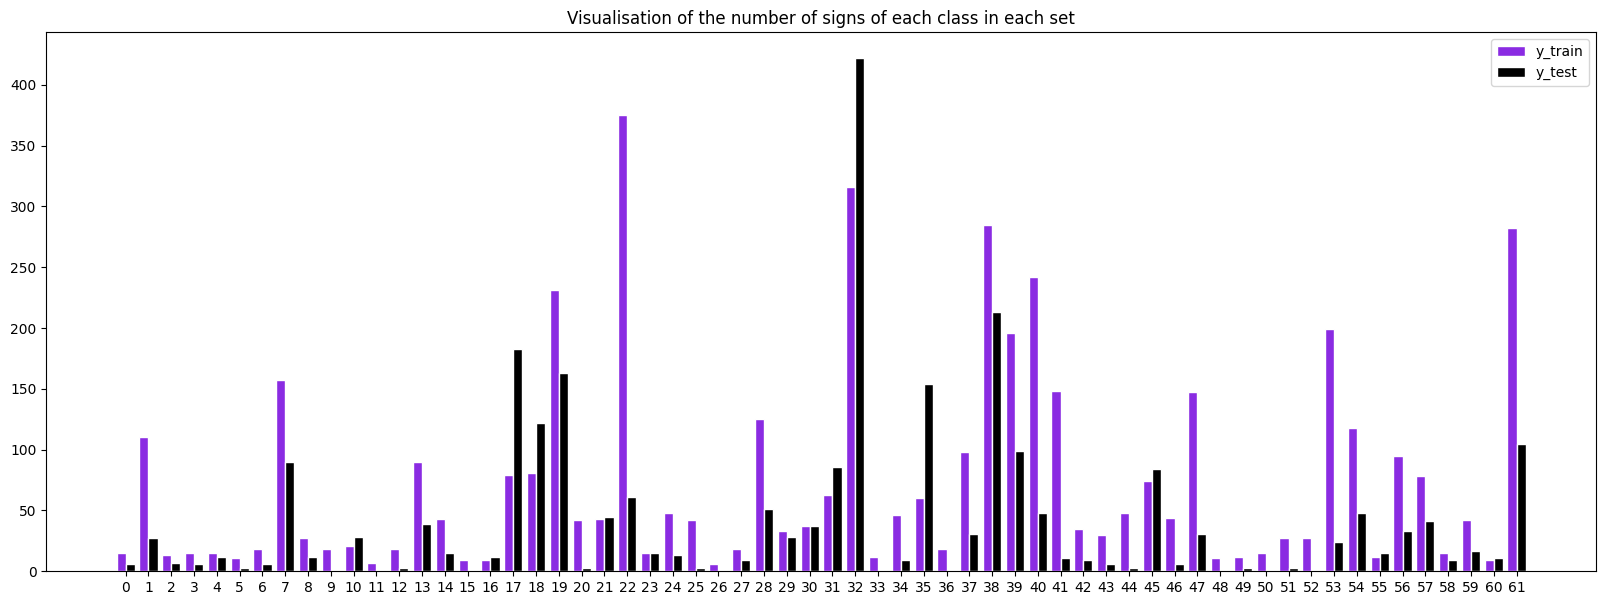

In [83]:
# This cell is about visualisation of the dataset 

a = np.zeros(nbr_class, dtype=int)
b = np.zeros(nbr_class, dtype=int)

for i in range(nbr_class) :
    a[i] = int((y_train == i).sum())  # Number of images of class i in the Training set
    b[i] = int((y_test == i).sum())   # Number of images of class i in the Test set 

print("Number of each sign in the train set : ")
print()
print(a)
print()
print("Total of signs : ", a.sum())
print()

print("Number of each sign in the test set : ")
print()
print(b)
print()
print("Total of signs : ", b.sum())

# We plot an histo showing how many signs of each class we have in each set 

fig, ax = plt.subplots(figsize = (20, 7))
bins = [x + 0.5 for x in range(-1, nbr_class)]
ax.hist([y_train, y_test], range = (0, nbr_class-1), bins=bins, edgecolor = 'white', color = ['blueviolet','black'], label = ['y_train', 'y_test'])
plt.title("Visualisation of the number of signs of each class in each set")
plt.xticks(np.arange(nbr_class))
plt.legend()
plt.show()

In [84]:

# talk : is it still necessary ?

'''
Augmentation de données :

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            "horizontal", input_shape=(64, 64, 3)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            mode="horizontal_and_vertical")
    ]
)

augmented_image = data_augmentation(X_train[a:b])
augmented_image = data_augmentation(X_test[c:d])
==> Augmente les images de X_train[a] à X_train[b] non compris et X_test[c] à X_test[d] non compris

idx = random.randint(a, b)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(X_train[idx])

plt.subplot(1, 2, 2)
plt.imshow(augmented_image[idx])

'''

'\nAugmentation de données :\n\ndata_augmentation = tf.keras.Sequential(\n    [\n        tf.keras.layers.experimental.preprocessing.RandomFlip(\n            "horizontal", input_shape=(64, 64, 3)),\n        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),\n        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),\n        tf.keras.layers.experimental.preprocessing.RandomFlip(\n            mode="horizontal_and_vertical")\n    ]\n)\n\naugmented_image = data_augmentation(X_train[a:b])\naugmented_image = data_augmentation(X_test[c:d])\n==> Augmente les images de X_train[a] à X_train[b] non compris et X_test[c] à X_test[d] non compris\n\nidx = random.randint(a, b)\nplt.figure()\nplt.subplot(1, 2, 1)\nplt.imshow(X_train[idx])\n\nplt.subplot(1, 2, 2)\nplt.imshow(augmented_image[idx])\n\n'

In [99]:
# This cell is about data augmentation 
# We'll randomize our initial set and do our augmentation with this (cells later)

# talk : Can we delete the error messages 
# talk : Is it really augmentation 

# Class to perform Random Erasing in Keras
class RandomErasing(tf.keras.layers.Layer):
    def __init__(self, probability=0.5, sl=0.02, sh=0.4, r1=0.3, mean=[0, 0, 0], **kwargs):
        super(RandomErasing, self).__init__(**kwargs)
        self.probability = probability
        self.sl = sl
        self.sh = sh
        self.r1 = r1
        self.mean = mean

    def call(self, inputs, training=None):
        if training:
            batch_size = tf.shape(inputs)[0]
            h, w = tf.shape(inputs)[1], tf.shape(inputs)[2]
            c = tf.shape(inputs)[3]
            area = h * w

            target_area = tf.random.uniform([], self.sl, self.sh) * area
            aspect_ratio = tf.random.uniform([], self.r1, 1 / self.r1)
            h_new = tf.cast(tf.math.sqrt(target_area * aspect_ratio), dtype=tf.int32)
            w_new = tf.cast(tf.math.sqrt(target_area / aspect_ratio), dtype=tf.int32)

            pad_h = h - h_new
            pad_w = w - w_new
            pad_h_top = tf.random.uniform([], 0, pad_h, dtype=tf.int32)
            pad_w_left = tf.random.uniform([], 0, pad_w, dtype=tf.int32)

            erase_area = tf.zeros([h_new, w_new], dtype=tf.float32)
            erase_area = tf.expand_dims(erase_area, axis=-1)
            erase_area = tf.tile(erase_area, [1, 1, c])
            erase_area = tf.pad(erase_area, [[pad_h_top, pad_h - pad_h_top], [pad_w_left, pad_w - pad_w_left], [0, 0]])
            erase_area = tf.image.random_flip_left_right(erase_area)

            mask = tf.ones_like(inputs)
            mask = tf.cast(mask, dtype=tf.float32)
            mask = tf.image.pad_to_bounding_box(mask, pad_h_top, pad_w_left, h, w)
            mask = tf.image.random_flip_left_right(mask)
            mask = tf.where(tf.equal(erase_area, 1), tf.zeros_like(mask), mask)

            inputs = tf.where(tf.equal(mask, 0), tf.ones_like(inputs) * np.array(self.mean, dtype=np.float32), inputs)

        return inputs



data_augmentation = tf.keras.Sequential(
    [
        # First, we'll flip the images randomly 
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            "horizontal", input_shape=(resol[0], resol[1], 3)),
        
        # Then, we rotate them randomly 
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),

        # We do random zooms 
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),

        # We change their orientation randomly 
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            mode="horizontal_and_vertical"),

        # We change the contrast randomly
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),

        # Finally we erase random parts of the images
        RandomErasing(probability=0.5, sl=0.02, sh=0.4, r1=0.3, mean=[0, 0, 0])

    ]
)

# We apply the augmentation on our datasets 
augmented_image_train = data_augmentation(X_train)
augmented_image_test = data_augmentation(X_test)

print("Shape of the randomized test set : ", augmented_image_test.shape)
print("Shape of the randomized training set : ", augmented_image_train.shape)

Shape of the randomized test set :  (2520, 30, 30, 3)
Shape of the randomized training set :  (4575, 30, 30, 3)


In [86]:
# First method of augmentation 
# If the training set has less than 3/4 of elements compared to the test set, we fill it with augmented images 

memory = np.zeros((nbr_class, 2), dtype=int)

counter_train = 0
counter_test = 0

for i in range(nbr_class) :
    
    if a[i] < 3*b[i]/4 :  

        if len(np.where(y_train == i)[0]) != 0 : # This would mean that we wouldn't see the sign in the training set 

            memory[i][0] = np.abs(3*b[i]/4 - a[i])
            counter_train += int(np.abs(3*b[i]/4 - a[i]))


# We create new sets that we'll fill with the data of the initial sets + the augmented data 

X_train_new_first = np.zeros((len(X_train) + counter_train, resol[0], resol[1], 3))
y_train_new_first = np.zeros(len(y_train) + counter_train)

X_train_new_first[:len(X_train)] = X_train
y_train_new_first[:len(y_train)] = y_train

X_test_new_first = np.zeros((len(X_test) + counter_test, resol[0], resol[1], 3))
y_test_new_first = np.zeros(len(y_test) + counter_test)

X_test_new_first[:len(X_test)] = X_test
y_test_new_first[:len(y_test)] = y_test

# We'll start adding values at this index

index_train = len(X_train)

a_first = a.copy()

for i in range(nbr_class) :

    if memory[i][0] > 0 : # We'll add it to the new set 
        
        indices = np.where(y_train == i) 
        augmented_image = tf.gather(augmented_image_train, indices=indices[0])

        for j in range(memory[i][0]) :

            a_first[i] += 1 

            idx = random.randint(0, len(indices[0])-1)

            X_train_new_first[index_train] = augmented_image[idx]
            y_train_new_first[index_train] = i
            index_train += 1

print("Shape of the augmented training set with first method : ", X_train_new_first.shape)
print("Shape of the augmented training target with first method : ", y_train_new_first.shape)
print("Shape of the augmented training set with first method : ", X_test_new_first.shape)
print("Shape of the augmented training target with first method : ", y_test_new_first.shape)

Shape of the augmented training set with first method :  (4699, 30, 30, 3)
Shape of the augmented training target with first method :  (4699,)
Shape of the augmented training set with first method :  (2520, 30, 30, 3)
Shape of the augmented training target with first method :  (2520,)


Number of each sign in the train set : 

[ 15 110  13  15  15  11  18 157  27  18  21   7  18  90  43   9   9 137
  91 231  42  43 375  15  48  42   6  18 125  33  37  64 316  12  46 115
  18  98 285 196 242 148  35  30  48  74  44 147  11  12  15  27  27 199
 118  12  95  78  15  42   9 282]

Total of signs :  4699

Number of each sign in the test set : 

[  6  27   7   6  12   3   6  90  12   0  28   0   3  39  15   0  12 183
 122 163   3  45  61  15  13   3   0   9  51  28  37  86 422   0   9 154
   0  31 213  99  48  11   9   6   3  84   6  31   0   3   0   3   0  24
  48  15  33  41   9  17  11 105]

Total of signs :  2520


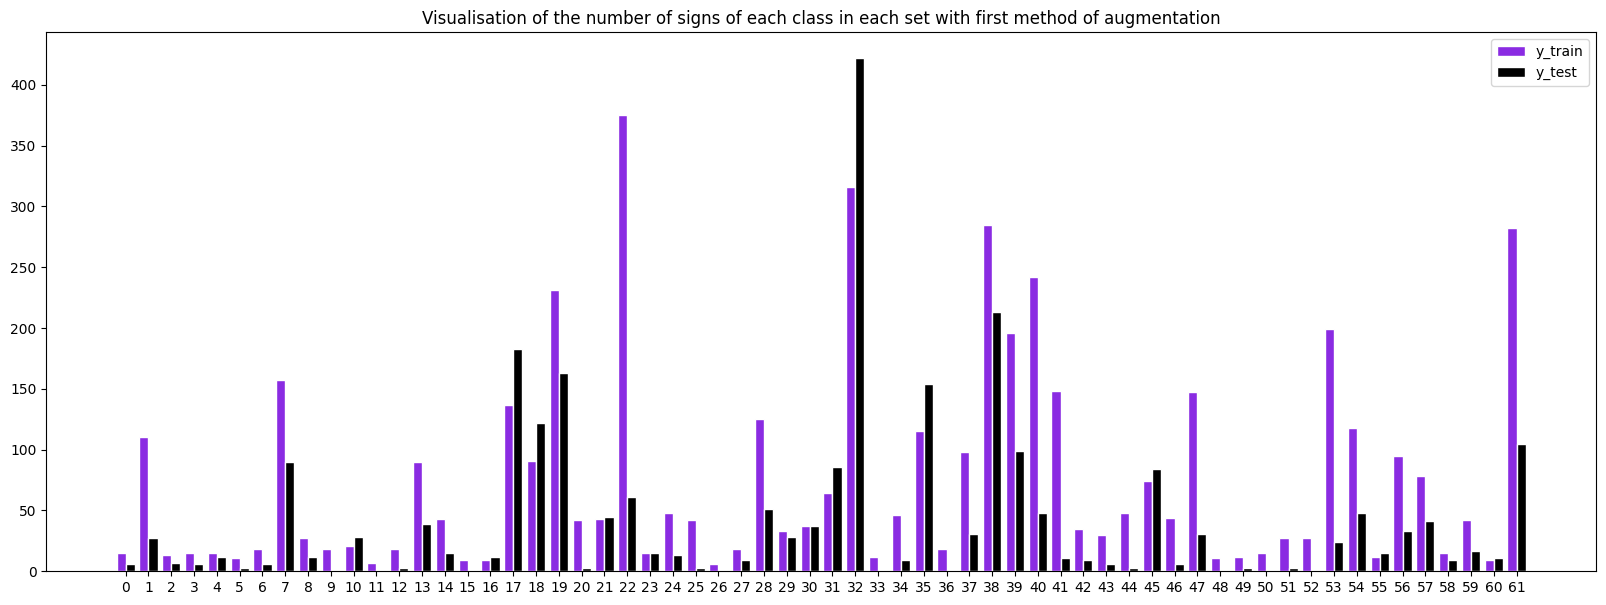

In [87]:
# Visualisation of the first method 

print("Number of each sign in the train set : ")
print()
print(a_first)
print()
print("Total of signs : ", a_first.sum())
print()

print("Number of each sign in the test set : ")
print()
print(b)
print()
print("Total of signs : ", b.sum())

fig, ax = plt.subplots(figsize = (20, 7))
bins = [x + 0.5 for x in range(-1, nbr_class)]
ax.hist([y_train_new_first, y_test_new_first], range = (0, nbr_class-1), bins=bins, edgecolor = 'white', color = ['blueviolet','black'], label = ['y_train', 'y_test'])
plt.title("Visualisation of the number of signs of each class in each set with first method of augmentation")
plt.xticks(np.arange(nbr_class))
plt.legend()
plt.show()

In [88]:
# Second method of data augmentation 
# All classes are represented with the same number of sign, the max already in 

memory = np.zeros(nbr_class, dtype=int)

lim = max(a)
counter = 0

for i in range(nbr_class) :

    memory[i] = lim - a[i]
    counter += lim - a[i]

# We create new sets that we'll fill with the data of the initial sets + the augmented data

X_train_new_second = np.zeros((len(X_train) + counter, resol[0], resol[1], 3))
y_train_new_second = np.zeros(len(y_train) + counter)

X_train_new_second[:len(X_train)] = X_train
y_train_new_second[:len(y_train)] = y_train

# We'll start adding values at this index

index = len(X_train)

a_second = a.copy() 

for i in range(nbr_class) :

    indices = np.where(y_train == i)
    augmented_image = tf.gather(augmented_image_train, indices=indices[0])

    for j in range(memory[i]) :

        idx = random.randint(0, len(indices[0])-1)

        a_second[i] += 1 

        X_train_new_second[index] = augmented_image[idx]
        y_train_new_second[index] = i
        index += 1

print("Shape of the augmented training set with second method : ", X_train_new_second.shape)
print("Shape of the augmented training target with second method : ", y_train_new_second.shape)

Shape of the augmented training set with second method :  (23250, 30, 30, 3)
Shape of the augmented training target with second method :  (23250,)


Number of each sign in the train set : 

[375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375
 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375
 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375
 375 375 375 375 375 375 375 375]

Total of signs :  23250

Number of each sign in the test set : 

[  6  27   7   6  12   3   6  90  12   0  28   0   3  39  15   0  12 183
 122 163   3  45  61  15  13   3   0   9  51  28  37  86 422   0   9 154
   0  31 213  99  48  11   9   6   3  84   6  31   0   3   0   3   0  24
  48  15  33  41   9  17  11 105]

Total of signs :  2520


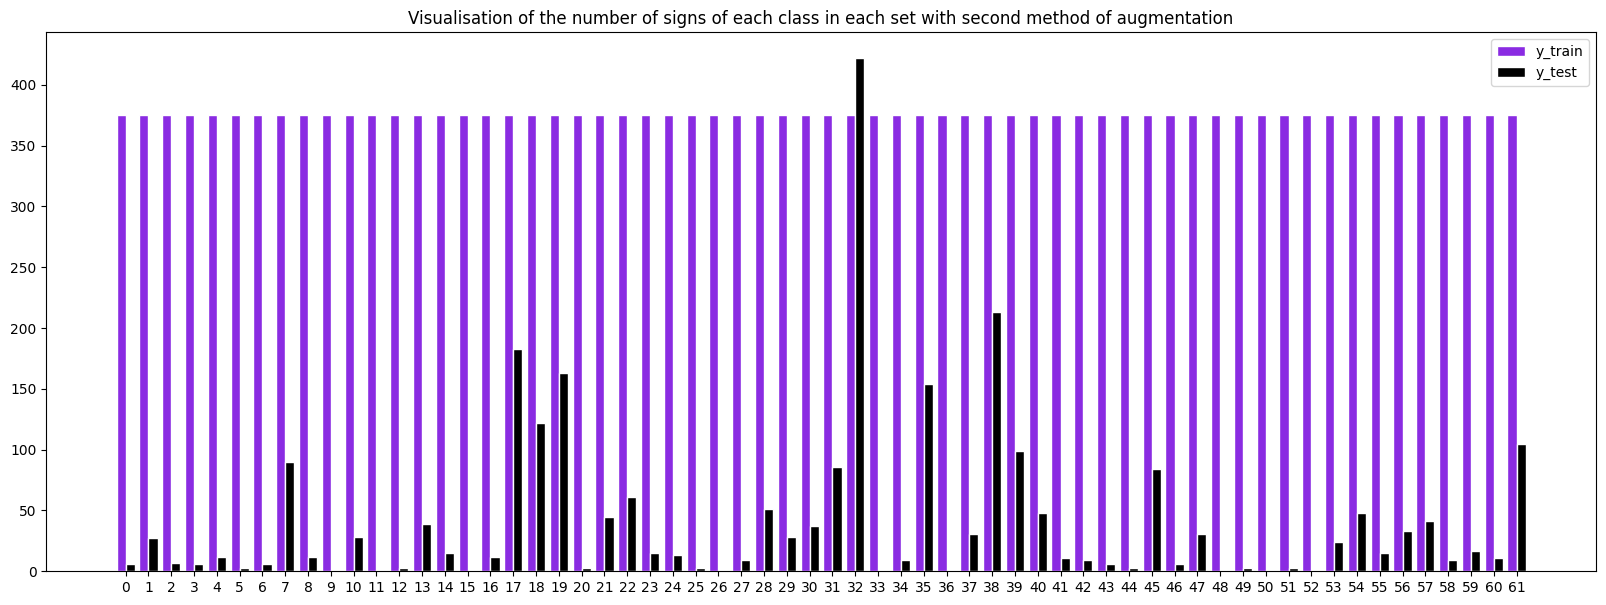

In [89]:
# Visualisation of the second method 

print("Number of each sign in the train set : ")
print()
print(a_second)
print()
print("Total of signs : ", a_second.sum())
print()

print("Number of each sign in the test set : ")
print()
print(b)
print()
print("Total of signs : ", b.sum())

X_test_new_second = X_test
y_test_new_second = y_test

fig, ax = plt.subplots(figsize = (20, 7))
bins = [x + 0.5 for x in range(-1, nbr_class)]
ax.hist([y_train_new_second, y_test_new_second], range = (0, nbr_class-1), bins=bins, edgecolor = 'white', color = ['blueviolet','black'], label = ['y_train', 'y_test'])
plt.title("Visualisation of the number of signs of each class in each set with second method of augmentation")
plt.xticks(np.arange(nbr_class))
plt.legend()
plt.show()

In [90]:
# We put our results to categorical 

# talk Some explanations needed ...

y_train_new_first = to_categorical(y_train_new_first, nbr_class)
y_test_new_first = to_categorical(y_test_new_first, nbr_class)

print("Shape of y_train with first method : ", y_train_new_first.shape)
print("Shape of y_test with first method : ", y_test_new_first.shape)

y_train_new_second = to_categorical(y_train_new_second, nbr_class)
y_test_new_second = to_categorical(y_test_new_second, nbr_class)

print("Shape of y_train with second method : ", y_train_new_second.shape)
print("Shape of y_test with second method : ", y_test_new_second.shape)

Shape of y_train with first method :  (4699, 62)
Shape of y_test with first method :  (2520, 62)
Shape of y_train with second method :  (23250, 62)
Shape of y_test with second method :  (2520, 62)


In [91]:
# We construct our model using CNN architecture (AlexNet, LeNet)

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train_new_first.shape[1:]) )
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(nbr_class, activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        2432      
                                                                 
 conv2d_9 (Conv2D)           (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 11, 11, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 9, 9, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 64)          36928     
                                                     

In [92]:
# We train here the model with the first method of augmentation 

eps = 5 # The number of time we want the model to train on the entire training_set

mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)]
anc = model.fit(X_train_new_first, y_train_new_first,validation_data=(X_test_new_first, y_test_new_first), epochs=eps, callbacks=mycallbacks)
#added aug.flow to (X_train, y_train) to do data augmentation
# validation_data=(X_test_new_first, y_test_new_first)
# validation_data=(X_test, y_test)

# talk : aug.flow ? 
# talk : validation data strange 

Epoch 1/5
147/147 [==============================] - 13s 79ms/step - loss: 3.1013 - accuracy: 0.2484 - val_loss: 1.6902 - val_accuracy: 0.5579
Epoch 2/5
147/147 [==============================] - 11s 77ms/step - loss: 1.5753 - accuracy: 0.6169 - val_loss: 0.9185 - val_accuracy: 0.7782
Epoch 3/5
147/147 [==============================] - 11s 74ms/step - loss: 0.9819 - accuracy: 0.7359 - val_loss: 0.5403 - val_accuracy: 0.8615
Epoch 4/5
147/147 [==============================] - 11s 75ms/step - loss: 0.7365 - accuracy: 0.7914 - val_loss: 0.4238 - val_accuracy: 0.8873
Epoch 5/5
147/147 [==============================] - 12s 81ms/step - loss: 0.5921 - accuracy: 0.8334 - val_loss: 0.3949 - val_accuracy: 0.8790


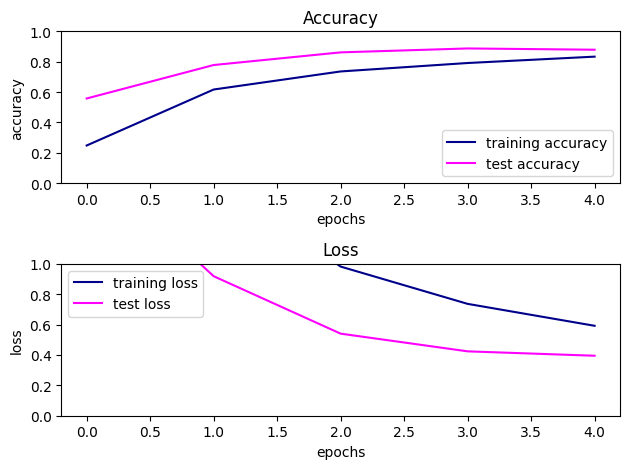

In [93]:
# Plot of performances 

plt.figure()

plt.subplot(2, 1, 1)
plt.plot(anc.history['accuracy'], label='training accuracy', color = 'darkblue')
plt.plot(anc.history['val_accuracy'], label='test accuracy', color = 'magenta')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.ylim(0, 1)

plt.subplot(2, 1, 2)
plt.plot(anc.history['loss'], label='training loss', color = 'darkblue')
plt.plot(anc.history['val_loss'], label='test loss', color = 'magenta')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [94]:
# Evaluate the network

label_names = open("dict.csv").read().strip().split("\n")[0:]
label_names = [l.split(",")[1] for l in label_names]

print("[INFO] evaluating network...")
predictions = model.predict(X_test_new_first) 
print(classification_report(y_test_new_first.argmax(axis=1),
	predictions.argmax(axis=1), target_names=label_names, labels=range(nbr_class-1)))


[INFO] evaluating network...
79/79 [==============================] - 1s 12ms/step
                                 precision    recall  f1-score   support

               "uneven_surface"       1.00      0.17      0.29         6
                         "bump"       0.73      1.00      0.84        27
                     "slippery"       1.00      0.86      0.92         7
                   "left_curve"       0.00      0.00      0.00         6
                  "right_curve"       0.00      0.00      0.00        12
                  "left_curves"       0.00      0.00      0.00         3
                 "right_curves"       0.00      0.00      0.00         6
                     "children"       0.82      0.78      0.80        90
                      "cyclist"       0.59      0.83      0.69        12
                      "animals"       0.00      0.00      0.00         0
                    "roadworks"       1.00      0.64      0.78        28
              "traffic_signals"       0.

In [95]:
# We construct our model using CNN architecture (AlexNet, LeNet)

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train_new_second.shape[1:]) )
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(nbr_class, activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        2432      
                                                                 
 conv2d_13 (Conv2D)          (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 11, 11, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 9, 9, 64)          18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 64)          36928     
                                                     

In [96]:
# We train here the model with the second method of augmentation 

eps = 5 # The number of time we want the model to train on the entire training_set

mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)]
anc = model.fit(X_train_new_second, y_train_new_second, validation_data=(X_test_new_second, y_test_new_second), epochs=eps, callbacks=mycallbacks)
#added aug.flow to (X_train, y_train) to do data augmentation

# talk : aug.flow ? 

Epoch 1/5
727/727 [==============================] - 55s 73ms/step - loss: 2.4391 - accuracy: 0.3265 - val_loss: 0.7591 - val_accuracy: 0.7683
Epoch 2/5
727/727 [==============================] - 51s 71ms/step - loss: 0.9249 - accuracy: 0.7091 - val_loss: 0.4196 - val_accuracy: 0.8722
Epoch 3/5
727/727 [==============================] - 59s 81ms/step - loss: 0.5796 - accuracy: 0.8188 - val_loss: 0.3684 - val_accuracy: 0.8806
Epoch 4/5
727/727 [==============================] - 58s 80ms/step - loss: 0.4386 - accuracy: 0.8606 - val_loss: 0.4226 - val_accuracy: 0.8810
Epoch 5/5
727/727 [==============================] - 61s 84ms/step - loss: 0.3593 - accuracy: 0.8872 - val_loss: 0.3358 - val_accuracy: 0.9060


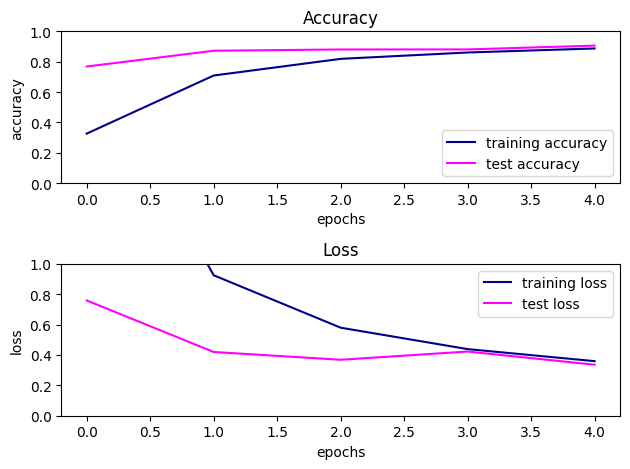

In [97]:
# Plot of performances 

plt.figure()

plt.subplot(2, 1, 1)
plt.plot(anc.history['accuracy'], label='training accuracy', color = 'darkblue')
plt.plot(anc.history['val_accuracy'], label='test accuracy', color = 'magenta')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.ylim(0, 1)

plt.subplot(2, 1, 2)
plt.plot(anc.history['loss'], label='training loss', color = 'darkblue')
plt.plot(anc.history['val_loss'], label='test loss', color = 'magenta')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [98]:
# Evaluate the network

label_names = open("dict.csv").read().strip().split("\n")[0:]
label_names = [l.split(",")[1] for l in label_names]

print("[INFO] evaluating network...")
predictions = model.predict(X_test_new_second) 
print(classification_report(y_test_new_second.argmax(axis=1),
	predictions.argmax(axis=1), target_names=label_names, labels=range(nbr_class-1)))

[INFO] evaluating network...
79/79 [==============================] - 1s 14ms/step
                                 precision    recall  f1-score   support

               "uneven_surface"       1.00      1.00      1.00         6
                         "bump"       0.84      1.00      0.92        27
                     "slippery"       0.88      1.00      0.93         7
                   "left_curve"       0.00      0.00      0.00         6
                  "right_curve"       0.57      0.33      0.42        12
                  "left_curves"       0.00      0.00      0.00         3
                 "right_curves"       0.67      0.67      0.67         6
                     "children"       0.90      0.91      0.91        90
                      "cyclist"       1.00      0.17      0.29        12
                      "animals"       0.00      0.00      0.00         0
                    "roadworks"       0.86      0.89      0.88        28
              "traffic_signals"       0.

A partir d'un ensemble de feature X_predict :

pred = model.predict_classes(X_predict)
print(accuracy_score(y_predict, pred))